In [8]:
using DrWatson
@quickactivate :ExtendedKalmanFilterNeuralTraining

using Plots, LaTeXStrings


(process:16912): GLib-GIO-WARNING **: 22:57:42.018: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.3.2.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 46 extensions but has no verbs


In [9]:
using LinearAlgebra: I, dot

function HIV_model(x)
    T = Dict{String,Any}()
    T_inf = Dict{String,Any}()
    M = Dict{String,Any}()
    M_inf = Dict{String,Any}()
    V = Dict{String,Any}()
    params = Dict{String,Any}()

    Q = Matrix(1.0e6I, 2, 2)
    R = 1.0e4
    η = 1.0
    P = Matrix(10.0I, 2, 2) 
    ω = rand(2)*1200 
    @pack! T = Q, R, η, P, ω

    Q = Matrix(1.0e6I, 2, 2)
    R = 1.0e4
    η = 1.0
    P = Matrix(10.0I, 2, 2)
    ω = rand(2)
    @pack! T_inf = Q, R, η, P, ω

    Q = Matrix(1.0e6I, 2, 2)
    R = 1.0e4
    η = 1.0
    P = Matrix(10.0I, 2, 2)
    ω = rand(2)
    @pack! M = Q, R, η, P, ω

    Q = Matrix(1.0e6I, 2, 2)
    R = 1.0e4
    η = 1.0
    P = Matrix(10.0I, 2, 2)
    ω = rand(2)*0.5
    @pack! M_inf = Q, R, η, P, ω

    Q = Matrix(1.0e6I, 3, 3)
    R = 1.0e4
    η = 2.0
    P = Matrix(10.0I, 3, 3)
    ω = rand(3)*2
    @pack! V = Q, R, η, P, ω

    params = Dict{String,Any}()
    @pack! params = T, T_inf, M, M_inf, V

    ϕ(v) = 1 / (1 + exp(-v))
    F(k) = Dict(
        "T" => (ω -> [dot(ω, [ϕ(x[k,"T"]), ϕ(x[k,"T"]) * ϕ(x[k,"V"])])]), 
        "T_inf" => (ω -> [dot(ω, [ϕ(x[k,"T"]) * ϕ(x[k,"V"]), ϕ(x[k,"T_inf"])])]), 
        "M" => (ω -> [dot(ω, [ϕ(x[k,"M"]) * ϕ(x[k,"V"]), ϕ(x[k,"V"])])]),
        "M_inf" => (ω -> [dot(ω, [ϕ(x[k,"M_inf"]) * ϕ(x[k,"V"]), ϕ(x[k,"M_inf"])])]),
        "V" => (ω -> [dot(ω, [ϕ(x[k,"T_inf"]), ϕ(x[k,"M_inf"]), ϕ(x[k,"V"])])])
        )

    return F, params
end

HIV_model (generic function with 1 method)

In [10]:
using ModelingToolkit, DifferentialEquations, DataFrames

@named hiv = HIV()
display(hiv)

HIV_tspan = (0.0, 365.0 * 10)
HIV_prob = ODEProblem(hiv, [], HIV_tspan)
HIV_sol = solve(HIV_prob);

x = DataFrame(hcat(map(HIV_sol, 0.0:2:max(HIV_tspan...))...)', ["T", "T_inf", "M", "M_inf", "V"]);
F, params = HIV_model(x)
X = train!(F, x, params; algorithm=EKF!());

Model hiv with 5 equations
States (5):
  T(t) [defaults to 1000.0]
  T_inf(t) [defaults to 0.0]
  M(t) [defaults to 150.0]
  M_inf(t) [defaults to 0.0]
⋮
Parameters (15):
  ρ_T [defaults to 0.01]
  C_T [defaults to 300]
  k_T [defaults to 4.57e-5]
  s_T [defaults to 10.0]
⋮

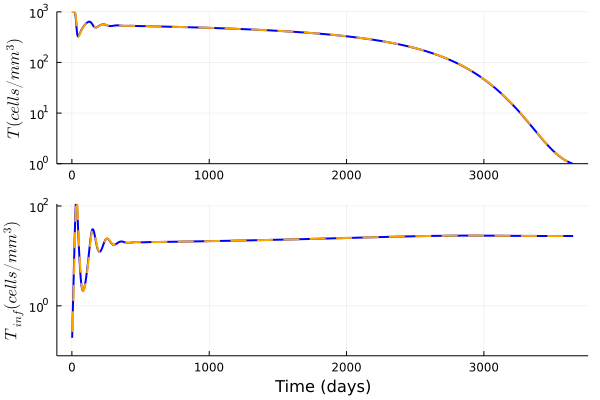

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\Dan

In [11]:
p1 = plot(0:2:max(HIV_tspan...), [x[!,"T"],X[!,"T"]], yscale=:log10, yrange=(1.0,1.0e3), ylabel=L"$T (cells/mm^3)$", lw=[2 2], c=[:blue :orange], ls=[:solid :dash], label=["HIV model" "RHONN"], legend=false)
p2 = plot(0:2:max(HIV_tspan...), [x[!,"T_inf"],X[!,"T_inf"]], yscale=:log10, yrange=(0.1,1.1e2), ylabel=L"$T_{inf} (cells/mm^3)$", lw=[2 2], c=[:blue :orange], ls=[:solid :dash], label=["HIV model" "RHONN"], xlabel="Time (days)", legend=false)
p3 = plot(p1, p2, layout=(2,1))
#savefig(p, joinpath(plotsdir(), "HIV_Tcells.png"))
p3

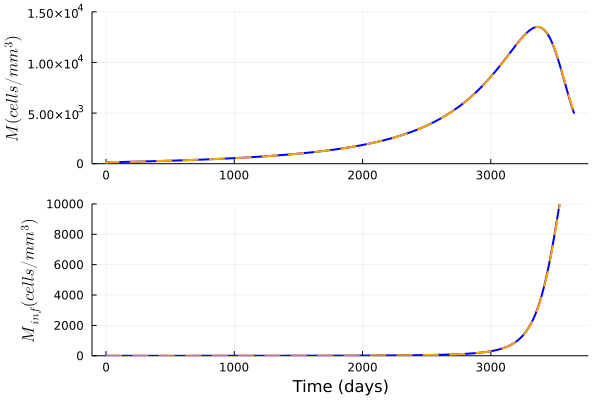

In [12]:
p1 = plot(0:2:max(HIV_tspan...), [x[!,"M"], X[!,"M"]], yrange=(0.0,1.5e4), ylabel=L"$M (cells/mm^3)$", lw=[2 2], c=[:blue :orange], ls=[:solid :dash], label=["HIV model" "RHONN"], legend=false)
p2 = plot(0:2:max(HIV_tspan...), [x[!,"M_inf"], X[!,"M_inf"]], yrange=(0.0,1.0e4), ylabel=L"$M_{inf}(cells/mm^3)$", lw=[2 2], c=[:blue :orange], ls=[:solid :dash], label=["HIV model" "RHONN"], xlabel="Time (days)", legend=false)
p4 = plot(p1, p2, layout=(2,1))
#savefig(p, joinpath(plotsdir(), "HIV_Mcells.png"))
p4


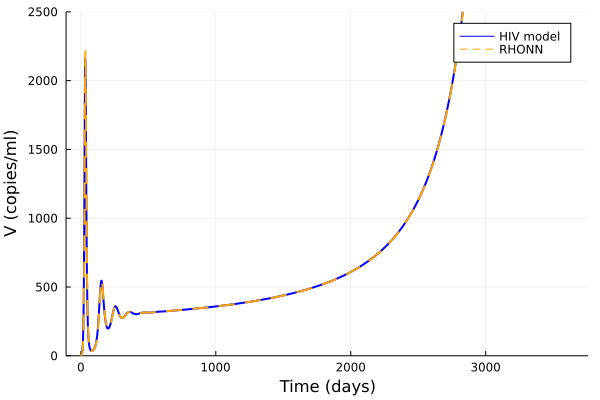

In [13]:
p5 = plot(0:2:max(HIV_tspan...), [x[!,"V"],X[!,"V"]], yrange=(0.0,2.5e3), ylabel="V (copies/ml)", lw=[2 2], c=[:blue :orange], ls=[:solid :dash], label=["HIV model" "RHONN"], xlabel="Time (days)")
#savefig(p, joinpath(plotsdir(), "HIV_virus.png"))
p5

## Regularization of Noisy Simulation

In [ ]:
@named hiv = HIV()
display(hiv)

HIV_tspan = (0.0, 365.0 * 10)
HIV_prob = ODEProblem(hiv, [], HIV_tspan)
HIV_sol = solve(HIV_prob);

x = DataFrame(hcat(map(HIV_sol, 0.0:2:max(HIV_tspan...))...)', ["T", "T_inf", "M", "M_inf", "V"]);

cutoff1 = 75
noiseQ1 = vcat(zeros(cutoff1) , ones(nrow(x)-cutoff1));

cutoff2 = 500
noiseQ2 = vcat(zeros(cutoff2) , ones(nrow(x)-cutoff2));

Model hiv with 5 equations
States (5):
  T(t) [defaults to 1000.0]
  T_inf(t) [defaults to 0.0]
  M(t) [defaults to 150.0]
  M_inf(t) [defaults to 0.0]
⋮
Parameters (15):
  ρ_T [defaults to 0.01]
  C_T [defaults to 300]
  k_T [defaults to 4.57e-5]
  s_T [defaults to 10.0]
⋮

### Weight's Comparison

In [ ]:
σ = 0.2
gaussian_noisy_x = mapcols(col -> max.(rand(MvNormal(col, σ * Diagonal(col .* noiseQ2))), 0.0), x);

In [ ]:
control = []
results = []
N = 100

for i in 1:N
    gaussian_noisy_x = mapcols(col -> max.(rand(MvNormal(col, σ * Diagonal(col .* noiseQ2))), 0.0), x);
    F, params = HIV_model(gaussian_noisy_x)
    X, W = RHONN(F, gaussian_noisy_x, params; algorithm=EKF!(), save_weights=true);
    push!(control, W)
end

for i in 1:N
    gaussian_noisy_x = mapcols(col -> max.(rand(MvNormal(col, σ * Diagonal(col .* noiseQ2))), 0.0), x);
    F, params = HIV_model(gaussian_noisy_x)
    ReX, W = RHONN(F, gaussian_noisy_x, params; algorithm=TikonovEKF!(α=2e14), save_weights=true);
    push!(results, W)
end

In [ ]:
p = plot(HIV_weights_plot(control), HIV_weights_plot(results), layout=(1,2), size=(1200,900))
#savefig(p, joinpath(plotsdir(), "noisy_sims", "ComPesos.png"))

### Plant State Comparison 

### Plots

In [14]:
function HIV_plot(Xarray::AbstractArray; size=(600, 450), lbl=["HIV model" "RHONN"], title=false, linealpha=[1.0 0.8 0.4])
    length(Xarray) == length(lbl) ? nothing : lbl = false
    l = @layout [a ; b c]
    p1 = plot(0:2:max(HIV_tspan...), [x[:,"T"] for x in Xarray], yscale=:log10, yrange=(1.0,1.0e3), ylabel=L"$T (cells/mm^3)$", lw=[2 for i in 1:length(Xarray)], ls=[:solid :dash :dashdot], label=lbl, legend=false, linealpha=linealpha)
    p2 = plot(0:2:max(HIV_tspan...), [x[:,"T_inf"] for x in Xarray], yscale=:log10, yrange=(0.1,1.1e2), ylabel=L"$T_{inf} (cells/mm^3)$", lw=[2 for i in 1:length(Xarray)], ls=[:solid :dash :dashdot], label=lbl, xlabel="Time (days)", legend=false, linealpha=linealpha)
    p3 = plot(p1, p2, layout=(2,1))
    p1 = plot(0:2:max(HIV_tspan...), [x[:,"M"] for x in Xarray], yrange=(0.0,1.5e4), ylabel=L"$M (cells/mm^3)$", lw=[2 for i in 1:length(Xarray)], ls=[:solid :dash :dashdot], label=lbl, legend=false, linealpha=linealpha)
    p2 = plot(0:2:max(HIV_tspan...), [x[:,"M_inf"] for x in Xarray], yrange=(0.0,1.0e4), ylabel=L"$M_{inf}(cells/mm^3)$", lw=[2 for i in 1:length(Xarray)], ls=[:solid :dash :dashdot], label=lbl, xlabel="Time (days)", legend=false, linealpha=linealpha)
    p4 = plot(p1, p2, layout=(2,1))
    p5 = plot(0:2:max(HIV_tspan...), [x[:,"V"] for x in Xarray], yrange=(0.0,2.5e3), ylabel="V (copies/ml)", lw=[2 for i in 1:length(Xarray)], ls=[:solid :dash :dashdot], label=lbl, xlabel="Time (days)", title=title, linealpha=linealpha)
    #savefig(p, joinpath(plotsdir(), "HIV_virus.png"))
    plot(p5, p3, p4, layout = l, size = size)
end
my_HIV_plot(X::DataFrame; size=(600, 450), lbl=["HIV model" "RHONN"], title=false) = my_HIV_plot([X]; size=size, lbl=lbl, title=title)

my_HIV_plot (generic function with 1 method)

In [15]:
function HIV_weights_plot(results::AbstractArray; size=(900,900), title=L"Pesos", linealpha=0.2)
    p1 = plot(ylabel=L"||T||")
    p2 = plot(ylabel=L"||T_{inf}||")
    p3 = plot(ylabel=L"||M||")
    p4 = plot(ylabel=L"||M_{inf}||")
    p5 = plot(ylabel=L"||V||", title=title)
    for i in 1:N
        @df results[i] plot!(p1, :T, c=:blue, linealpha=linealpha, legend=false )
        @df results[i] plot!(p2, :T_inf, c=:blue, linealpha=linealpha, legend=false )
        @df results[i] plot!(p3, :M, c=:blue, linealpha=linealpha, legend=false )
        @df results[i] plot!(p4, :M_inf, c=:blue, linealpha=linealpha, legend=false )
        @df results[i] plot!(p5, :V, c=:blue, linealpha=linealpha, legend=false)
    end
    l = @layout [a ; b c]
    return plot(p5, plot(p1, p2, layout=(2,1)), plot(p3, p4, layout=(2,1)), layout = l, size=(600,900))
end

LoadError: LoadError: UndefVarError: @df not defined
in expression starting at c:\Users\Daniel I Parra Verde\OneDrive\Documentos\Proyectos\ExtendedKalmanFilterNeuralTraining\scripts\VIH_Noisy_Dynamic_Identification.ipynb:8

#### Noisy start at Transitory - Animations

In [ ]:
σ = 0.2
uniform_noisy_x = mapcols(col -> col + σ * col .* noiseQ1 .* (rand(Float64, size(col)) * 2 .- 1), x);
F, params = HIV_model(uniform_noisy_x)
X, W = RHONN(F, uniform_noisy_x, params; algorithm=EKF!(), save_weights=true);

In [ ]:
p1 = my_HIV_plot([uniform_noisy_x, X]; size=(600, 600), lbl=["HIV model" "RHONN"], title="Identification")
p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e4])
p = plot(p1, p2, layout= (1,2), size=(1200, 600))
savefig(p, plotsdir("noisy_sims","transitory","uniform_noise_RHONN_Weights.png"))
p

In [ ]:
anim = @animate for i in [2e6, 2e7, 2e8, 2e9, 2e10, 2e11, 2e10, 2e11, 2e12, 2e13, 2e14, 2e15, 2e16, 2e17, 2e18, 2e19, 2e20]
    F, params = HIV_model(uniform_noisy_x)
    ReX, W = RHONN(F, uniform_noisy_x, params; algorithm=TikonovEKF!(α=i), save_weights=true);
    p1 = my_HIV_plot([uniform_noisy_x, ReX]; size=(600, 600), lbl=["HIV model" "ReRHONN = $(i)"], title="Identification")
    p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e5])
    plot(p1, p2, layout= (1,2), size=(1200, 600)) 
end

gif(anim, plotsdir("noisy_sims", "transitory", "L2", "uniform_noise_RHONN_Weights.gif"), fps = 5)


In [ ]:
σ = 2.0
gaussian_noisy_x = mapcols(col -> (rand(MvNormal(col, σ * Diagonal(col .* noiseQ1)))), x);
F, params = HIV_model(gaussian_noisy_x)
X, W = RHONN(F, gaussian_noisy_x, params; algorithm=EKF!(), save_weights=true);

In [ ]:
p1 = my_HIV_plot([gaussian_noisy_x, X]; size=(600, 600), lbl=["HIV model" "RHONN"], title="Identification")
p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e4])
p = plot(p1, p2, layout= (1,2), size=(1200, 600))
savefig(p, plotsdir("noisy_sims","transitory","gaussian_noise_RHONN_Weights.png"))
p

In [ ]:
anim = @animate for i in [2e6, 2e7, 2e8, 2e9, 2e10, 2e11, 2e10, 2e11, 2e12, 2e13, 2e14, 2e15, 2e16, 2e17, 2e18, 2e19, 2e20]
    F, params = HIV_model(gaussian_noisy_x)
    ReX, W = RHONN(F, gaussian_noisy_x, params; algorithm=TikonovEKF!(α=i), save_weights=true);
    p1 = my_HIV_plot([gaussian_noisy_x, ReX]; size=(600, 600), lbl=["HIV model" "ReRHONN = $(i)"], title="Identification")
    p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e5])
    plot(p1, p2, layout= (1,2), size=(1200, 600)) 
end

gif(anim, plotsdir("noisy_sims","transitory","L2", "gaussian_noise_RHONN_Weights.gif"), fps = 5)

#### Noisy start at Stationary - Animations

In [ ]:
σ = 0.2
uniform_noisy_x = mapcols(col -> col + σ * col .* noiseQ2 .* (rand(Float64, size(col)) * 2 .- 1), x);
F, params = HIV_model(uniform_noisy_x)
X, W = RHONN(F, uniform_noisy_x, params; algorithm=EKF!(), save_weights=true);

In [ ]:
p1 = my_HIV_plot([uniform_noisy_x, X]; size=(600, 600), lbl=["HIV model" "RHONN"], title="Identification")
p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e4])
p = plot(p1, p2, layout= (1,2), size=(1200, 600))
savefig(p, plotsdir("noisy_sims","stationary","uniform_noise_RHONN_Weights.png"))
p

In [ ]:
anim = @animate for i in [2e6, 2e7, 2e8, 2e9, 2e10, 2e11, 2e10, 2e11, 2e12, 2e13, 2e14, 2e15, 2e16, 2e17, 2e18, 2e19, 2e20]
    F, params = HIV_model(uniform_noisy_x)
    ReX, W = RHONN(F, uniform_noisy_x, params; algorithm=TikonovEKF!(α=i), save_weights=true);
    p1 = my_HIV_plot([uniform_noisy_x, ReX]; size=(600, 600), lbl=["HIV model" "ReRHONN = $(i)"], title="Identification")
    p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e5])
    plot(p1, p2, layout= (1,2), size=(1200, 600)) 
end

gif(anim, plotsdir("noisy_sims", "stationary", "L2", "uniform_noise_ReRHONN.gif"), fps = 5)

In [ ]:
σ = 2.0
gaussian_noisy_x = mapcols(col -> (rand(MvNormal(col, σ * Diagonal(col .* noiseQ2)))), x);
F, params = HIV_model(gaussian_noisy_x)
X, W = RHONN(F, gaussian_noisy_x, params; algorithm=EKF!(), save_weights=true);

In [ ]:
p1 = my_HIV_plot([gaussian_noisy_x, X]; size=(600, 600), lbl=["HIV model" "RHONN"], title="Identification")
p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e4])
p = plot(p1, p2, layout= (1,2), size=(1200, 600))
savefig(p, plotsdir("noisy_sims","stationary","gaussian_noise_RHONN_Weights.png"))
p

In [ ]:
anim = @animate for i in [2e6, 2e7, 2e8, 2e9, 2e10, 2e11, 2e10, 2e11, 2e12, 2e13, 2e14, 2e15, 2e16, 2e17, 2e18, 2e19, 2e20]
    F, params = HIV_model(uniform_noisy_x)
    ReX, W = RHONN(F, gaussian_noisy_x, params; algorithm=TikonovEKF!(α=i), save_weights=true);
    p1 = my_HIV_plot([gaussian_noisy_x, ReX]; size=(600, 600), lbl=["HIV model" "ReRHONN = $(i)"], title="Identification")
    p2 = @df W plot(cols(propertynames(W)), title="Weights", lw = 2, size=(600, 600), yrange=[0.0,1.0e5])
    plot(p1, p2, layout= (1,2), size=(1200, 600)) 
end

gif(anim, plotsdir("noisy_sims","stationary", "L2", "gaussian_noise_RHONN_Weights.gif"), fps = 5)